In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
# import tensorflow as tf

# tf.compat.v1.enable_eager_execution()

In [4]:
import malaya_speech
import tensorflow as tf
from malaya_speech.train.model import fastsplit, fastspeech, sepformer
from malaya_speech.train.model.transformer import encoder
import malaya_speech.augmentation.waveform as augmentation
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




In [5]:
from glob import glob

wavs = glob('../speech/example-speaker/*.wav')
len(wavs)

8

In [6]:
import random

sr = 8000
speakers_size = 4

# noise = malaya_speech.load('noise.wav', sr = sr)[0]

def read_wav(f):
    return malaya_speech.load(f, sr = sr)


def random_sampling(s, length):
    return augmentation.random_sampling(s, sr = sr, length = length)

def to_mel(y):
    mel = malaya_speech.featurization.universal_mel(y)
    mel[mel <= np.log(1e-2)] = np.log(1e-2)
    return mel

def combine_speakers(files, n = 5, limit = 4):
    w_samples = random.sample(files, n)
    w_samples = [read_wav(f)[0] for f in w_samples]
    w_lens = [len(w) / sr for w in w_samples]
    w_lens = int(min(min(w_lens) * 1000, random.randint(2000, 10000)))
    w_samples = [random_sampling(w, length = w_lens) for w in w_samples]
    y = [w_samples[0]]
    left = w_samples[0].copy()

    combined = None

    for i in range(1, n):
        right = w_samples[i].copy()
        overlap = random.uniform(0.98, 1.0)
        print(i, overlap)
        len_overlap = int(overlap * len(right))
        minus = len(left) - len_overlap
        if minus < 0:
            minus = 0
        padded_right = np.pad(right, (minus, 0))
        left = np.pad(left, (0, len(padded_right) - len(left)))

        left = left + padded_right

        if i >= (limit - 1):
            if combined is None:
                combined = padded_right
            else:
                combined = np.pad(
                    combined, (0, len(padded_right) - len(combined))
                )
                combined += padded_right

        else:
            y.append(padded_right)

    if combined is not None:
        y.append(combined)
        
    maxs = [max(left)]
    for i in range(len(y)):
        if len(y[i]) != len(left):
            y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
            maxs.append(max(y[i]))
            
    max_amp = max(maxs)
    mix_scaling = 1 / max_amp * 0.95
    left = left * mix_scaling
    
    for i in range(len(y)):
        y[i] = y[i] * mix_scaling

#     for i in range(len(y)):
#         if len(y[i]) != len(left):
#             y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
#             y[i] = y[i] / np.max(np.abs(y[i]))

#     left = left / np.max(np.abs(left))
        
    return left, y

# y, _ = malaya_speech.load('../speech/example-speaker/husein-zolkepli.wav')
# y = np.expand_dims(y, 0).astype(np.float32)
# y.shape

In [7]:
left, y = combine_speakers(wavs, 6)
len(left) / sr, len(y)

1 0.9842002459365695
2 0.9965253686912678
3 0.9862580505403438
4 0.9849841905629431
5 0.9855110208221116


(3.738125, 4)

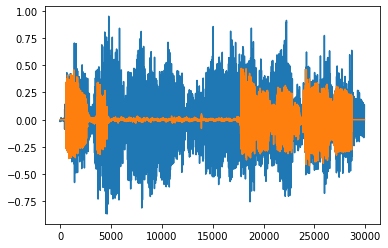

In [8]:
import matplotlib.pyplot as plt

plt.plot(left)
plt.plot(y[2])

In [9]:
import IPython.display as ipd

ipd.Audio(left, rate = sr)

In [10]:
# https://github.com/speechbrain/speechbrain/blob/develop/recipes/WSJ0Mix/separation/hparams/sepformer-wham.yaml#L111
config = malaya_speech.config.transformer_config
dim = 256
config['hidden_size'] = dim
config['num_hidden_layers'] = 10
config['attention_dropout'] = 0.0
config['relu_dropout'] = 0.0
config['filter_size'] = 1024
config['norm_before'] = True

In [11]:
transformer = lambda: encoder.Encoder(config, train = True)

In [12]:
model = sepformer.Model(transformer, transformer)

In [13]:
X = tf.placeholder(tf.float32, [None, None, 1])
len_X = tf.placeholder(tf.int32, [None])
logits = model(X)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.


In [14]:
logits

<tf.Tensor 'sepformer/cond/Merge:0' shape=(4, ?, ?, 1) dtype=float32>

In [15]:
estimate_source = tf.transpose(logits[:,:,:,0], [1, 0, 2])

In [16]:
C = 4
Y = tf.placeholder(tf.float32, [None, C, None])

In [17]:
loss, max_snr, _ = sepformer.calculate_loss(Y, Y, len_X, C = C)

In [18]:
# X = tf.convert_to_tensor(np.expand_dims([left], axis = -1).astype(np.float32))
# logits = model(X)

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
l = sess.run(logits, feed_dict = {X: np.expand_dims([left, left], axis = -1)})
l.shape

(4, 2, 29905, 1)

In [21]:
sess.run(loss, feed_dict = {X: np.expand_dims([left], axis = -1), len_X: [len(left)], Y: [y]})

-102.97557

In [22]:
sess.run(max_snr, feed_dict = {X: np.expand_dims([left], axis = -1), len_X: [len(left)], Y: [y]})

array([[102.97557]], dtype=float32)

In [23]:
saver = tf.train.Saver()

In [24]:
saver.save(sess, 'test/model.ckpt')

'test/model.ckpt'

In [25]:
!ls -lh test

total 266688
-rw-r--r--  1 huseinzolkepli  staff    77B May  4 22:40 checkpoint
-rw-r--r--  1 huseinzolkepli  staff   122M May  4 22:40 model.ckpt.data-00000-of-00001
-rw-r--r--  1 huseinzolkepli  staff    26K May  4 22:40 model.ckpt.index
-rw-r--r--  1 huseinzolkepli  staff   7.8M May  4 22:40 model.ckpt.meta


In [26]:
!rm -rf test

In [27]:
# tf.trainable_variables()